In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import random
import cv2
import torch
import os
import glob
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torchvision import models
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

2024-06-18 10:08:26.993037: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-18 10:08:26.993162: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-18 10:08:27.116678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
! wget http://images.cocodataset.org/zips/test2014.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-06-18 10:08:37--  http://images.cocodataset.org/zips/test2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.162.113, 52.217.236.57, 52.217.113.97, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.162.113|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6660437059 (6.2G) [application/zip]
Saving to: 'test2014.zip'

test2014.zip        100%[===================>]   6.20G  54.4MB/s    in 2m 11s  

2024-06-18 10:10:48 (48.4 MB/s) - 'test2014.zip' saved [6660437059/6660437059]



In [ ]:
!unzip test2014.zip

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
def add_salt_and_pepper_noise(image, salt_prob=0.002, pepper_prob=0.002):
     noisy_image = np.copy(image)
     total_pixels = image.shape[0] * image.shape[1]
    
     num_salt = np.ceil(salt_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_salt)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 1

     num_pepper = np.ceil(pepper_prob * total_pixels)
     coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in image.shape[:2]]
     noisy_image[coords[0], coords[1], :] = 0

     return noisy_image

def add_poisson_noise(image):
    vals = len(np.unique(image))
    vals = 3 ** np.ceil(np.log2(vals))
    noisy_image = np.random.poisson(image * vals) / float(vals)
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image*0.8

def add_gaussian_noise(image, mean=0, std=0.07):
    image = image.astype(np.float32)
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_image = image + noise
    noisy_image = np.clip(noisy_image, 0, 1)
    
    return noisy_image

In [7]:
class NoiseImageDataset(Dataset):
    
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        target_size = (128,128)
        image = cv2.resize(image,target_size,interpolation=cv2.INTER_LINEAR)
        
        image = image.astype(np.float32) / 255.0
        
        noise_image = add_salt_and_pepper_noise(image)
        noise_image = add_poisson_noise(noise_image)
        noise_image = add_gaussian_noise(noise_image)
        
        image = torch.tensor(image).permute(2, 0, 1)
        noise_image = torch.tensor(noise_image).permute(2, 0, 1)
        
        return  noise_image.to(device) ,image.to(device)

In [8]:
image_directory = '/kaggle/working/test2014'
image_paths = glob.glob(os.path.join(image_directory, '*.jpg'))
dataset = NoiseImageDataset(image_paths)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

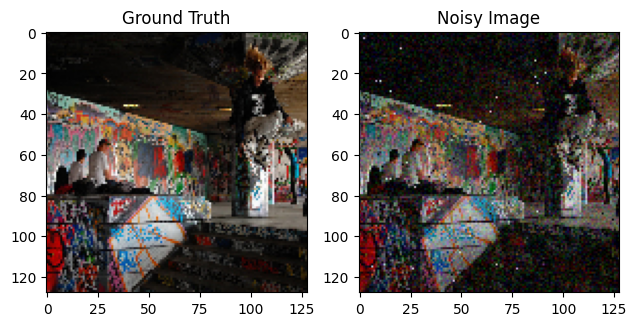

In [9]:
#Visualizing first image of first two batches in dataloader for reference :
for index ,(noise,image) in enumerate(dataloader):
    if index == 0:
        noise = noise[0].squeeze().permute(1, 2, 0).cpu().numpy()
        image = image[0].squeeze().permute(1, 2, 0).cpu().numpy()

        noise = (noise * 255).astype(int)
        image = (image * 255).astype(int)
        
        plt.figure(figsize=(80, 20))
        
        plt.subplot(1,20,2)
        plt.title('Noisy Image')
        plt.imshow(noise, cmap='gray')
        
        plt.subplot(1,20,1)
        plt.title('Ground Truth')
        plt.imshow(image, cmap='gray')

        plt.show()
        
    if index == 1:
        break;

In [10]:
class UNet(nn.Module):
  def __init__(self):
    super(UNet,self).__init__()

    self.downsample = nn.Sequential(

        nn.Conv2d(3, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(64, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Conv2d(128, 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.Conv2d(256, 256, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

    )

    self.upsample = nn.Sequential(

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(256, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(128, 128, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(negative_slope=0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(128, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope=0.01, inplace= True),
        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(64, 64, kernel_size = 3, padding = 1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(negative_slope = 0.01, inplace = True),
        nn.MaxPool2d(2),

        nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True),
        nn.Conv2d(64, 3, kernel_size = 3, padding = 1),
        nn.ReLU()
    )

  def forward(self,x):
    ds = self.downsample(x)
    output = self.upsample(ds)

    return output

In [11]:
class PerceptualLoss(nn.Module):
  def __init__(self):
    super(PerceptualLoss ,self).__init__()
    vgg19 = models.vgg19(pretrained=True).features[:36].eval()
    for param in vgg19.parameters():
      param.requires_grad = False
    self.vgg19 = vgg19
    self.criterion = nn.MSELoss()

  def forward(self, output, target):
    output_fea = self.vgg19(output)
    target_fea = self.vgg19(target)

    return self.criterion(output_fea , target_fea)

In [12]:
percep_loss = PerceptualLoss().to(device)
net = UNet().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 30

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:03<00:00, 168MB/s]  


In [ ]:
writer = SummaryWriter('runs/colorization')
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for image,noise in progress_bar:
        
        image = image.to(device)
        noise = noise.to(device)
        
        optimizer.zero_grad()

        output = net(noise)
        output.shape
        image.shape
        pixel_loss = nn.MSELoss()(output,image)
        
        p_loss = percep_loss(output, image)
        loss = pixel_loss + 0.1 * p_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss/len(dataloader)
  

    if (epoch+1) == 10 or epoch+1 == 20 or epoch+1 == 15 or epoch+1 == 25:
        torch.save(net.state_dict(),f"/kaggle/working/{epoch+1}_unet_ploss_vgg19.pth")
    
    writer.add_scalar('LOSS/EPOCH', avg_epoch_loss, epoch)

    print(f"Epoch {epoch+1} , Loss:{avg_epoch_loss}")

torch.save(net.state_dict() , "/kaggle/working/30_unet_ploss_vgg19.pth")
writer.close()

Epoch 1/30: 100%|██████████| 319/319 [11:57<00:00,  2.25s/it]


Epoch 1 , Loss:0.03689533178942704


Epoch 2/30: 100%|██████████| 319/319 [11:58<00:00,  2.25s/it]


Epoch 2 , Loss:0.0330790180105681


Epoch 3/30: 100%|██████████| 319/319 [12:00<00:00,  2.26s/it]


Epoch 3 , Loss:0.030944679440422493


Epoch 4/30: 100%|██████████| 319/319 [12:01<00:00,  2.26s/it]


Epoch 4 , Loss:0.029473597662622652


Epoch 5/30: 100%|██████████| 319/319 [11:59<00:00,  2.26s/it]


Epoch 5 , Loss:0.02838354708983046


Epoch 6/30: 100%|██████████| 319/319 [11:52<00:00,  2.23s/it]


Epoch 6 , Loss:0.027419706100019915


Epoch 7/30: 100%|██████████| 319/319 [11:54<00:00,  2.24s/it]


Epoch 7 , Loss:0.026711441342920344


Epoch 8/30: 100%|██████████| 319/319 [12:01<00:00,  2.26s/it]


Epoch 8 , Loss:0.026294286926291578


Epoch 9/30: 100%|██████████| 319/319 [12:00<00:00,  2.26s/it]


Epoch 9 , Loss:0.025578891584024908


Epoch 10/30: 100%|██████████| 319/319 [11:58<00:00,  2.25s/it]


Epoch 10 , Loss:0.025134344646549525


Epoch 11/30: 100%|██████████| 319/319 [11:56<00:00,  2.25s/it]


Epoch 11 , Loss:0.02488697468533785


Epoch 12/30: 100%|██████████| 319/319 [12:01<00:00,  2.26s/it]


Epoch 12 , Loss:0.024465220060701655


Epoch 13/30: 100%|██████████| 319/319 [12:05<00:00,  2.28s/it]


Epoch 13 , Loss:0.024042488213009597


Epoch 14/30: 100%|██████████| 319/319 [12:06<00:00,  2.28s/it]


Epoch 14 , Loss:0.023668006593857812


Epoch 15/30: 100%|██████████| 319/319 [12:07<00:00,  2.28s/it]


Epoch 15 , Loss:0.023635332201108288


Epoch 16/30: 100%|██████████| 319/319 [12:07<00:00,  2.28s/it]


Epoch 16 , Loss:0.023624511353881755


Epoch 17/30: 100%|██████████| 319/319 [12:05<00:00,  2.27s/it]


Epoch 17 , Loss:0.023080406278418522


Epoch 18/30: 100%|██████████| 319/319 [12:02<00:00,  2.27s/it]


Epoch 18 , Loss:0.022826836891122


Epoch 19/30: 100%|██████████| 319/319 [12:07<00:00,  2.28s/it]


Epoch 19 , Loss:0.02256052379954758


Epoch 20/30: 100%|██████████| 319/319 [12:09<00:00,  2.29s/it]


Epoch 20 , Loss:0.022354891027402728


Epoch 21/30:  18%|█▊        | 58/319 [02:10<09:51,  2.27s/it]

<h4>Training Broke here so i had to restart it by loading the 15 epoch model that was saved by it and then i continued its training. </h4>

In [18]:
percep_loss = PerceptualLoss().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)
num_epochs = 10

In [19]:
model = UNet()
model_path = '/kaggle/input/15epoch-model/15epochs'
model.load_state_dict(torch.load(model_path,map_location=device))
model = model.to(device)
model.eval()

UNet(
  (downsample): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.01, inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
   

In [20]:
writer = SummaryWriter('runs/colorization')
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for image,noise in progress_bar:
        
        image = image.to(device)
        noise = noise.to(device)
        
        optimizer.zero_grad()

        output = model(noise)
        output.shape
        image.shape
        pixel_loss = nn.MSELoss()(output,image)
        
        p_loss = percep_loss(output, image)
        loss = pixel_loss + 0.1 * p_loss
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss/len(dataloader)
  
    
    if (epoch+1) == 5:
        torch.save(model.state_dict(),f"/kaggle/working/20_unet_ploss_vgg19.pth")
    
    writer.add_scalar('LOSS/EPOCH', avg_epoch_loss, epoch)

    print(f"Epoch {epoch+1} , Loss:{avg_epoch_loss}")

torch.save(model.state_dict() , "/kaggle/working/25_unet_ploss_vgg19.pth")
writer.close()

Epoch 1/10: 100%|██████████| 319/319 [11:54<00:00,  2.24s/it]


Epoch 1 , Loss:0.024844715751263787


Epoch 2/10: 100%|██████████| 319/319 [11:55<00:00,  2.24s/it]


Epoch 2 , Loss:0.024857425495842033


Epoch 3/10: 100%|██████████| 319/319 [11:52<00:00,  2.23s/it]


Epoch 3 , Loss:0.0248709317109895


Epoch 4/10: 100%|██████████| 319/319 [11:54<00:00,  2.24s/it]


Epoch 4 , Loss:0.024838893315214723


Epoch 5/10: 100%|██████████| 319/319 [11:53<00:00,  2.24s/it]


Epoch 5 , Loss:0.02486371928037708


Epoch 6/10: 100%|██████████| 319/319 [11:52<00:00,  2.23s/it]


Epoch 6 , Loss:0.024869440917544602


Epoch 8/10: 100%|██████████| 319/319 [11:54<00:00,  2.24s/it]


Epoch 8 , Loss:0.024853297669825882


Epoch 9/10: 100%|██████████| 319/319 [11:51<00:00,  2.23s/it]


Epoch 9 , Loss:0.024862507550880826


Epoch 10/10: 100%|██████████| 319/319 [11:50<00:00,  2.23s/it]

Epoch 10 , Loss:0.024862305719557228


In [21]:
def psnr(gt_image, pred_images, max_val=1.0):
    mse = torch.mean((gt_image - pred_images) ** 2)
    psnr_val = 10 * torch.log10((max_val ** 2) / mse)
    return psnr_val

def calculate_psnr(data_loader, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    psnr_sum = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch_idx, (noisy, gt_image) in enumerate(data_loader):
            noisy = noisy.to(device)
            pred_images = model(noisy)

            psnr_batch = psnr(gt_image, pred_images)

            psnr_sum += torch.sum(psnr_batch)
            num_batches += 1

    avg_psnr = psnr_sum / num_batches
    return avg_psnr.item()

In [22]:
psnr = calculate_psnr(dataloader,model)
print(psnr)

13.935431480407715
